<div class="alert alert-info">
<strong>ИТОГОВАЯ АТТЕСТАЦИЯ<strong>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import missingno as msno
import warnings

from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats
from sklearn.base import TransformerMixin, BaseEstimator, OneToOneFeatureMixin
from sklearn.cross_decomposition import PLSRegression
from xgboost import XGBRegressor
from phik.report import plot_correlation_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["font.size"] = 12
plt.style.use("dark_background")
param_plt = {"linewidth": 3, "color": "darkblue"}
pd.set_option("display.max_colwidth", None)

2024-08-18 23:12:12.556997: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 23:12:12.654210: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 23:12:12.680374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 23:12:12.846705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-18 23:12:14.447588: W tensorflow/compiler/tf2

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 1.Загрузка и предобработка данных</div>

In [2]:
# !kaggle datasets download -d hellbuoy/car-price-prediction

In [3]:
# %mkdir dataset_car-price-prediction
# !unzip -q car-price-prediction.zip -d dataset_car-price-prediction

In [4]:
try:
    df = pd.read_csv("dataset_car-price-prediction/CarPrice_Assignment.csv")
    workbook = openpyxl.load_workbook(
        "dataset_car-price-prediction/Data Dictionary - carprices.xlsx"
    )
    sheet = workbook.active
    features_dct = []
    for row in sheet.iter_rows(min_row=5, max_row=31, values_only=True):
        tmp = []
        for cell in range(len(row)):
            cell = row[cell]
            if cell != None and not isinstance(cell, int):
                tmp.append(cell)
        if tmp != []:
            features_dct.append(tmp)
    features_dct = pd.DataFrame(features_dct, columns=[["feature", "information"]])
except FileNotFoundError:
    print("You have to load the file to the directory before opening it.")

Посмотрим список признаков.

In [5]:
features_dct

,feature,information
0,Car_ID,Unique id of each observation (Interger)
1,Symboling,"Its assigned insurance risk rating, A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.(Categorical)"
2,carCompany,Name of car company (Categorical)
3,fueltype,Car fuel type i.e gas or diesel (Categorical)
4,aspiration,Aspiration used in a car (Categorical)
5,doornumber,Number of doors in a car (Categorical)
6,carbody,body of car (Categorical)
7,drivewheel,type of drive wheel (Categorical)
8,enginelocation,Location of car engine (Categorical)
9,wheelbase,Weelbase of car (Numeric)


In [6]:
print(f"Количество дубликатов: {df[df.duplicated()].shape[0]}")

Количество дубликатов: 0


In [7]:
df.car_ID.nunique() == len(df)

True

Столбец car_ID содержит уникальные айди, он нам не пригодится. Удалим его.

In [8]:
df.drop("car_ID", axis=1, inplace=True)

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 2. Описательный анализ данных, просмотр данных и вывод статистики.</div>

In [9]:
df.head()

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         205 non-null    int64  
 1   CarName           205 non-null    object 
 2   fueltype          205 non-null    object 
 3   aspiration        205 non-null    object 
 4   doornumber        205 non-null    object 
 5   carbody           205 non-null    object 
 6   drivewheel        205 non-null    object 
 7   enginelocation    205 non-null    object 
 8   wheelbase         205 non-null    float64
 9   carlength         205 non-null    float64
 10  carwidth          205 non-null    float64
 11  carheight         205 non-null    float64
 12  curbweight        205 non-null    int64  
 13  enginetype        205 non-null    object 
 14  cylindernumber    205 non-null    object 
 15  enginesize        205 non-null    int64  
 16  fuelsystem        205 non-null    object 
 1

В датасете 16 числовых и 10 категориальных столбцов.\
Пропусков нет.

Рассмотрим числовые столбцы.

In [11]:
num_features = df.select_dtypes(include="number").drop(columns=["price"])

In [12]:
pd.concat(
    [
        num_features.nunique().to_frame(name="unique"),
        num_features.describe().T,
    ],
    join="outer",
    axis=1,
).style.background_gradient(subset=["mean", "50%"], cmap="Blues_r")

,unique,count,mean,std,min,25%,50%,75%,max
symboling,6,205.000000,0.834146,1.245307,-2.000000,0.000000,1.000000,2.000000,3.000000
wheelbase,53,205.000000,98.756585,6.021776,86.600000,94.500000,97.000000,102.400000,120.900000
carlength,75,205.000000,174.049268,12.337289,141.100000,166.300000,173.200000,183.100000,208.100000
carwidth,44,205.000000,65.907805,2.145204,60.300000,64.100000,65.500000,66.900000,72.300000
carheight,49,205.000000,53.724878,2.443522,47.800000,52.000000,54.100000,55.500000,59.800000
curbweight,171,205.000000,2555.565854,520.680204,1488.000000,2145.000000,2414.000000,2935.000000,4066.000000
enginesize,44,205.000000,126.907317,41.642693,61.000000,97.000000,120.000000,141.000000,326.000000
boreratio,38,205.000000,3.329756,0.270844,2.540000,3.150000,3.310000,3.580000,3.940000
stroke,37,205.000000,3.255415,0.313597,2.070000,3.110000,3.290000,3.410000,4.170000
compressionratio,32,205.000000,10.142537,3.972040,7.000000,8.600000,9.000000,9.400000,23.000000


Распределение по всем столбцам на первый взляд нормальное (mean==50%).\
Столбец curbweight содержит 171 уникальное значение, скорее всего его нужно укрупнить для работы.

In [13]:
IQR = pd.DataFrame(
    {
        "min": num_features.min(),
        "max": num_features.max(),
        "Q1": num_features.quantile(0.25),
        "Q3": num_features.quantile(0.75),
    }
)
IQR["iqr"] = IQR["Q3"] - IQR["Q1"]
IQR["outlier-"] = IQR["Q3"] - IQR["iqr"] * 1.5
IQR["outlier+"] = IQR["Q1"] + IQR["iqr"] * 1.5
IQR.drop(columns=["Q1", "Q3", "iqr"], axis=1, inplace=True)
IQR

,min,max,outlier-,outlier+
symboling,-2.00,3.00,-1.000,3.000
wheelbase,86.60,120.90,90.550,106.350
carlength,141.10,208.10,157.900,191.500
carwidth,60.30,72.30,62.700,68.300
carheight,47.80,59.80,50.250,57.250
curbweight,1488.00,4066.00,1750.000,3330.000
enginesize,61.00,326.00,75.000,163.000
boreratio,2.54,3.94,2.935,3.795
stroke,2.07,4.17,2.960,3.560
compressionratio,7.00,23.00,8.200,9.800


Тут уже видно, что есть выбросы, особенно в столбцах: curbweight, enginesize.

In [14]:
cat_features = df.select_dtypes(include="object")

In [15]:
cat_features.describe()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
count,205,205,205,205,205,205,205,205,205,205
unique,147,2,2,2,5,3,2,7,7,8
top,toyota corona,gas,std,four,sedan,fwd,front,ohc,four,mpfi
freq,6,185,168,115,96,120,202,148,159,94


В данных присутствует столбец с большим кол-вом категориальных значений - CarName.\
Посмотрим его.

In [16]:
df.CarName.str.split().str[0].str.lower().value_counts().sort_values(
    ascending=False
).to_frame(name="count").reset_index(names="model").style.background_gradient(
    cmap="Blues_r"
)

,model,count
0,toyota,31
1,nissan,18
2,mazda,15
3,honda,13
4,mitsubishi,13
5,subaru,12
6,peugeot,11
7,volvo,11
8,dodge,9
9,volkswagen,9


Мы видим ряд ошибочно написанных названий.\
Заменим их при визуализации.\
Также видно, что большая часть автомобилей из датасета относится к японским маркам.


## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 3. Визуализация.</div>

Посмотрим на пропуски.

<Axes: >

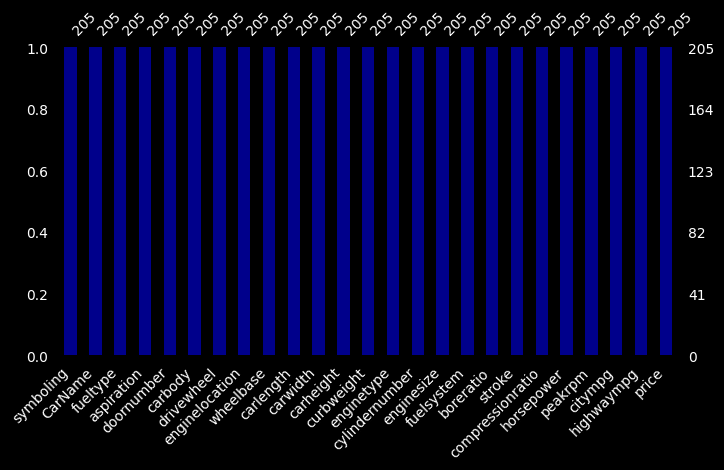

In [17]:
msno.bar(df, color="darkblue", figsize=(8, 4), fontsize=10)

Посмотрим на целевой признак.

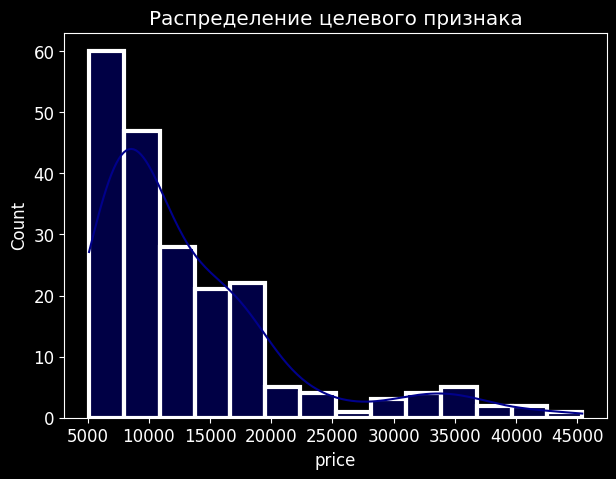

In [18]:
plt.title("Распределение целевого признака")
sns.histplot(df, x=df.price, kde=True, **param_plt)
plt.show()

In [19]:
df.price.value_counts(bins=5, normalize=True)

(5077.717, 13174.4]    0.624390
(13174.4, 21230.8]     0.258537
(29287.2, 37343.6]     0.058537
(21230.8, 29287.2]     0.043902
(37343.6, 45400.0]     0.014634
Name: price, dtype: float64

Распределение скошено, основная масса автомобилей (87%) имеет цену до 21.000.

Посмотрим на числовые столбцы.

In [20]:
num_features.shape

(205, 14)

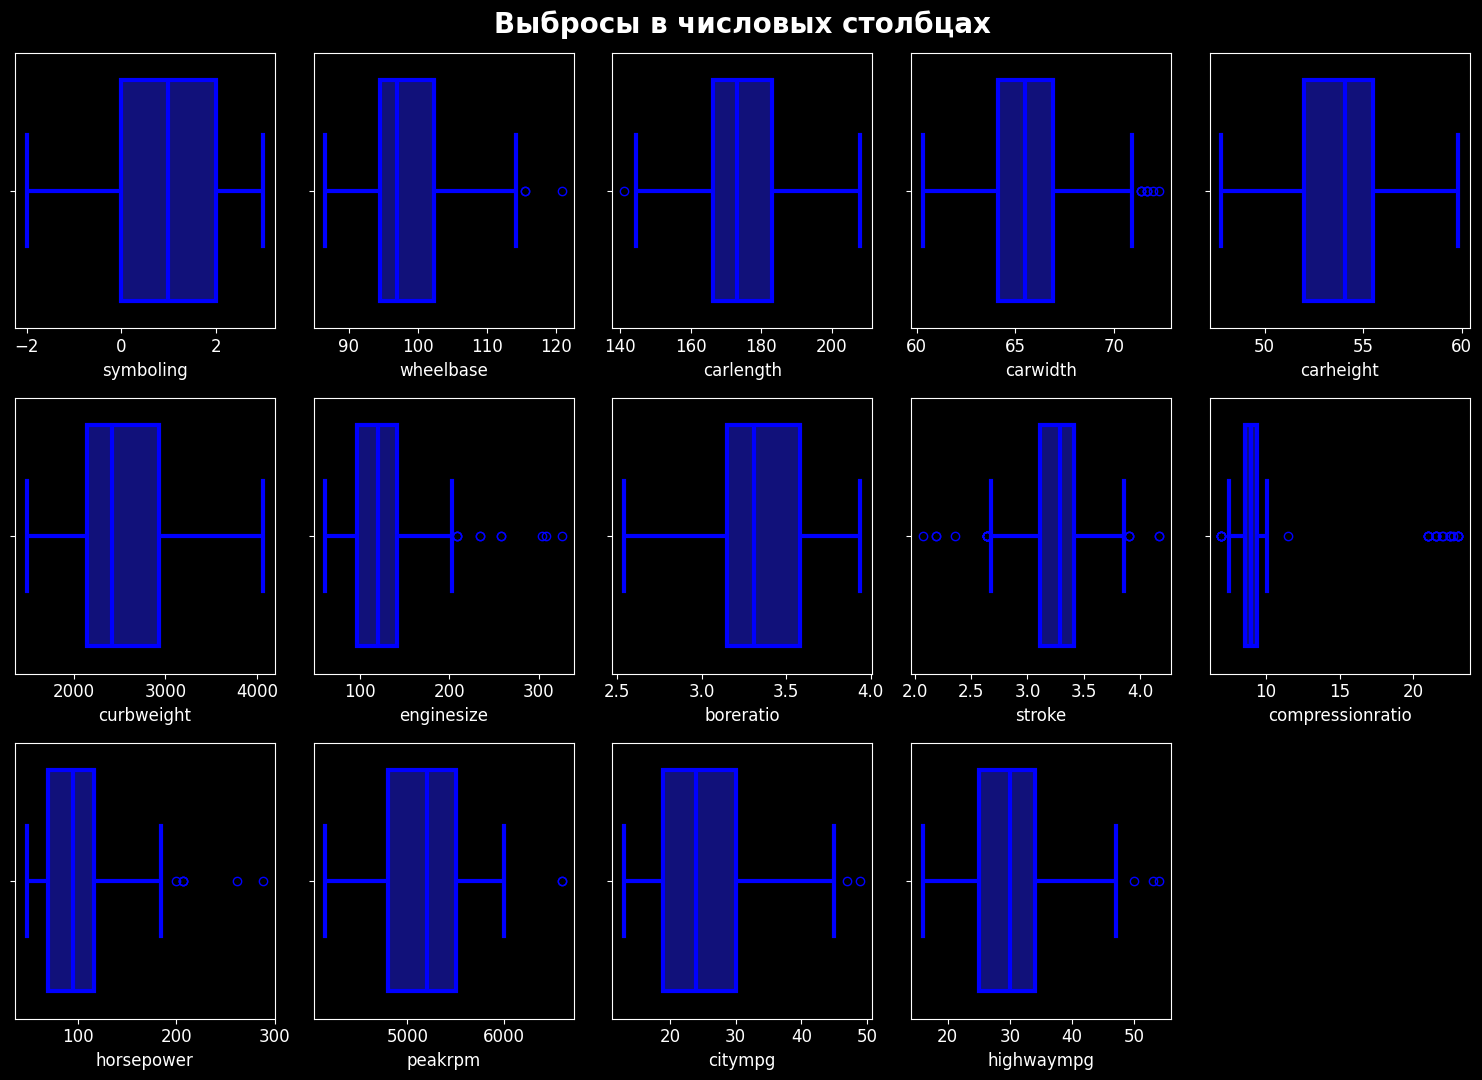

In [21]:
fig, ax = plt.subplots(3, 5, figsize=(15, 11))
fig.suptitle("Выбросы в числовых столбцах", fontsize=20, fontweight="bold")
i, j = 0, 0

for feat in num_features:
    sns.boxplot(df, x=feat, ax=ax[i][j], linecolor="blue", **param_plt)
    j += 1
    if j == 5:
        i += 1
        j = 0
ax[2][4].remove()
plt.tight_layout()
plt.show()

In [22]:
df.loc[df.carlength < 145]

,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
18,2,chevrolet impala,gas,std,two,hatchback,fwd,front,88.4,141.1,...,61,2bbl,2.91,3.03,9.5,48,5100,47,53,5151.0
30,2,honda civic,gas,std,two,hatchback,fwd,front,86.6,144.6,...,92,1bbl,2.91,3.41,9.6,58,4800,49,54,6479.0
31,2,honda civic cvcc,gas,std,two,hatchback,fwd,front,86.6,144.6,...,92,1bbl,2.91,3.41,9.2,76,6000,31,38,6855.0


In [23]:
df.loc[df.carwidth > 70].groupby("carbody")["carwidth"].agg("count")

carbody
convertible    1
hardtop        2
hatchback      1
sedan          8
wagon          2
Name: carwidth, dtype: int64

Очевидно, что длина (carlength), колесная база (wheelbase), ширина (carwidth), объем двигателя (enginesize) и лс (horsepower) автомобиля в пределах нормального значения.\
Также можно предположить корреляцию между объемом двигателя и кол-вом лс.\
Также можно предположить корреляцию между пробегом по городу(citympg) и трассе(highwaympg).

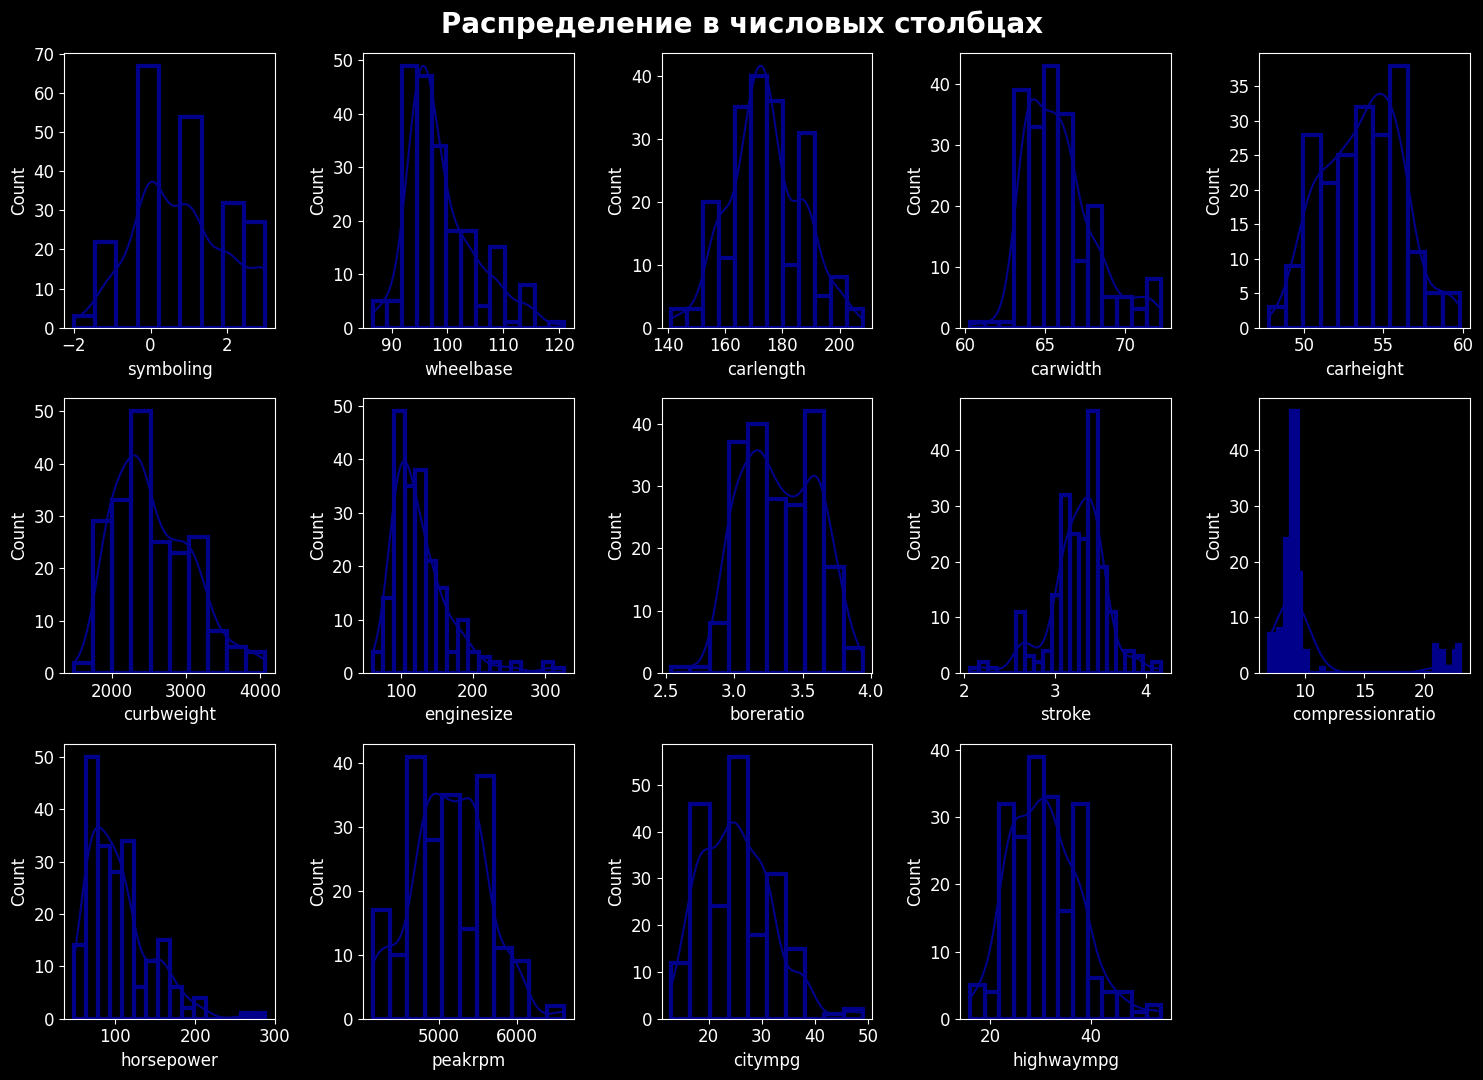

In [24]:
fig, ax = plt.subplots(3, 5, figsize=(15, 11))
fig.suptitle("Распределение в числовых столбцах", fontsize=20, fontweight="bold")
i, j = 0, 0

for feat in num_features:
    sns.histplot(df, x=feat, ax=ax[i][j], kde=True, fill=False, **param_plt)
    j += 1
    if j == 5:
        i += 1
        j = 0
ax[2][4].remove()
plt.tight_layout()
plt.show()

В данных есть распределения скошенные (wheelbase, carwidth, enginesize, horsepower).\
Есть столбец с распределением далеким от нормального - compressionratio. Посмотрим на него подробнее.

In [25]:
df.compressionratio.value_counts(bins=5)

(6.983, 10.2]    184
(19.8, 23.0]      20
(10.2, 13.4]       1
(13.4, 16.6]       0
(16.6, 19.8]       0
Name: compressionratio, dtype: int64

Это связано с разным значением степени сжатия двигателя для авто бензиновых и дизельных. Проверим это в данных.

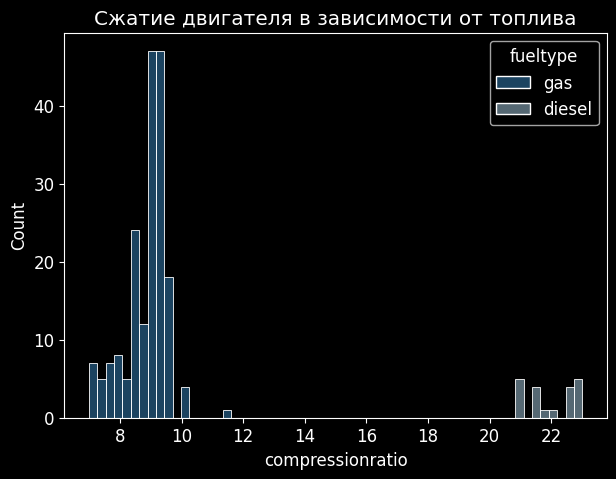

In [26]:
plt.title("Сжатие двигателя в зависимости от топлива")
sns.histplot(df, x=df.compressionratio, hue=df.fueltype, palette="Blues_r")
plt.show()

Посмотрим на категориальные столбцы.

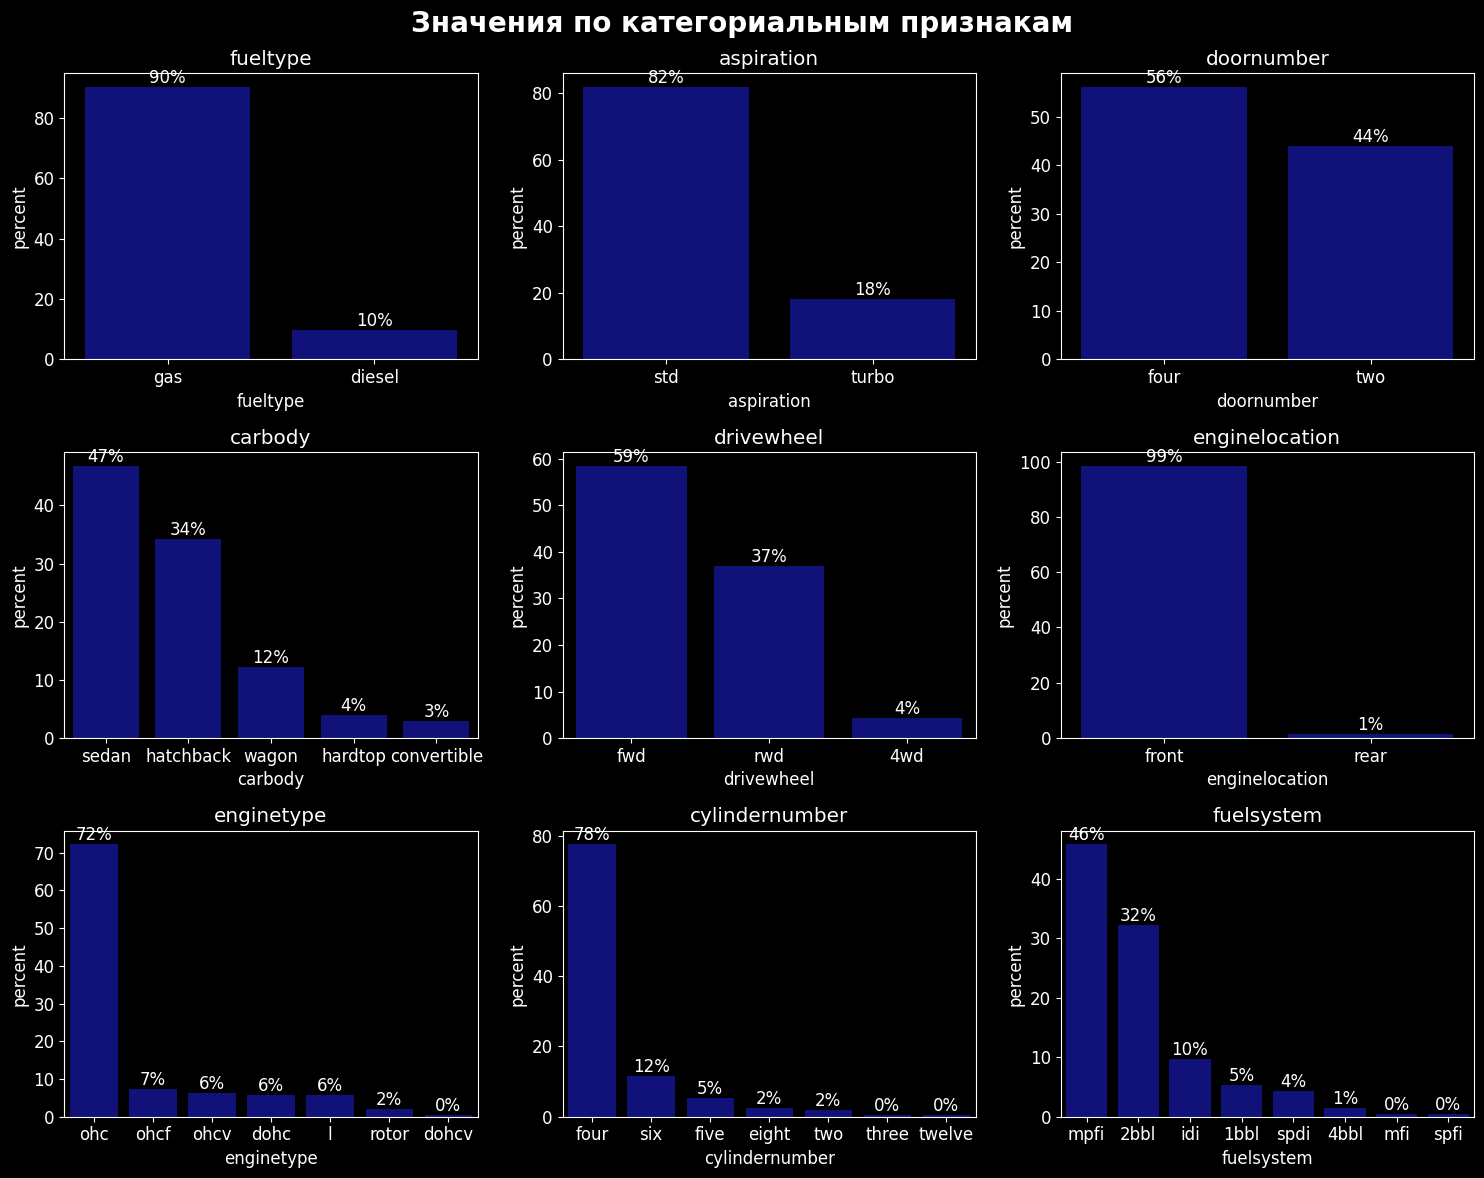

In [27]:
fig, ax = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Значения по категориальным признакам", fontsize=20, fontweight="bold")
i, j = 0, 0

for feat in cat_features.drop("CarName", axis=1):
    pl = sns.countplot(
        cat_features,
        x=feat,
        ax=ax[i][j],
        stat="percent",
        order=cat_features[feat].value_counts().index,
        **param_plt
    )
    ax[i][j].set_title(feat)
    pl.bar_label(pl.containers[0], fmt="%.f%%")
    j += 1
    if j == 3:
        i += 1
        j = 0

plt.tight_layout()
plt.show()

В данных есть столбец, где распределение между значениями 99 на 1: enginelocation.\
Это соответствует жизни, но сколько всего значений в 1%?

In [28]:
len(df.loc[df.enginelocation == "rear"])

3

Есть столбцы cylindernumber и fuelsystem, где ряд значений занимает менее 1%. Возможно, есть смысл объединить такие значения.

Посмотрим на корреляцию признаков.

interval columns not set, guessing: ['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'price']


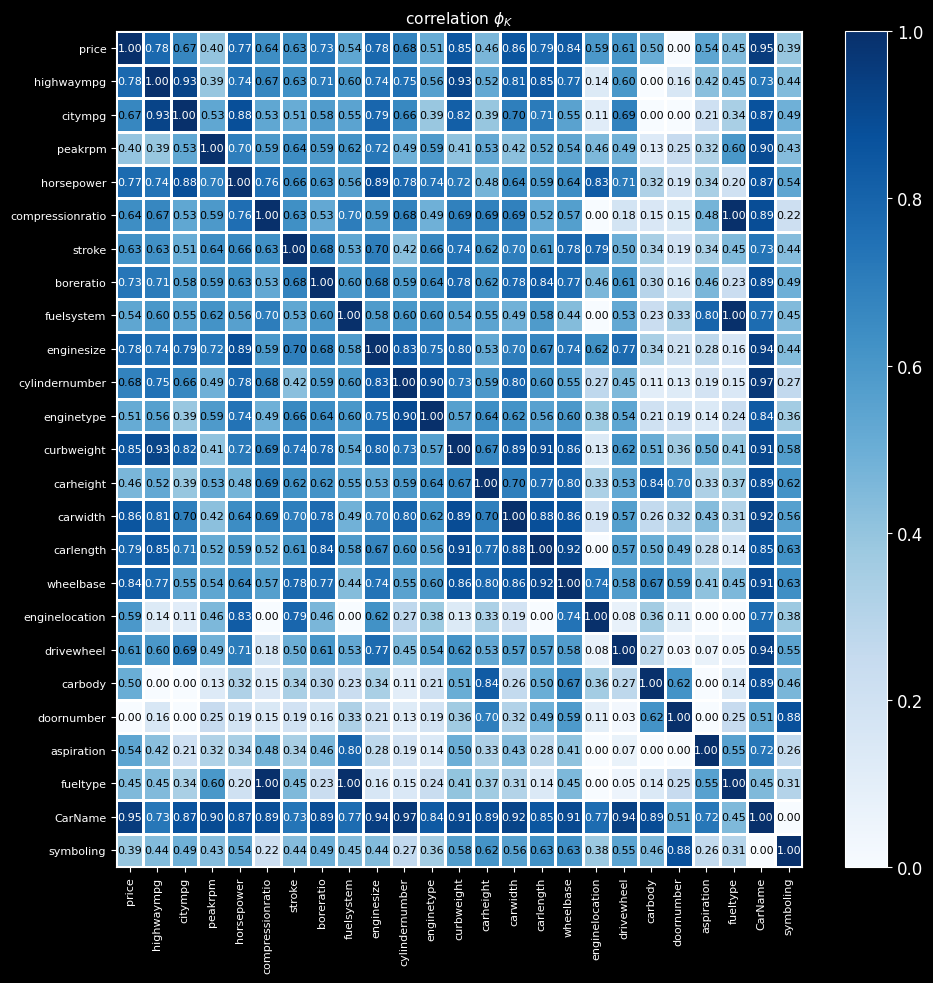

In [29]:
phik_overview = df.phik_matrix()

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    color_map="Blues",
    title=r"correlation $\phi_K$",
    fontsize_factor=0.8,
    figsize=(10, 10),
)
plt.tight_layout()

Мы видим, что по ряду признаков очень высокая (свыше 0.9) корреляция.
Посмотрим на них и на корреляцию с целевым признаком.

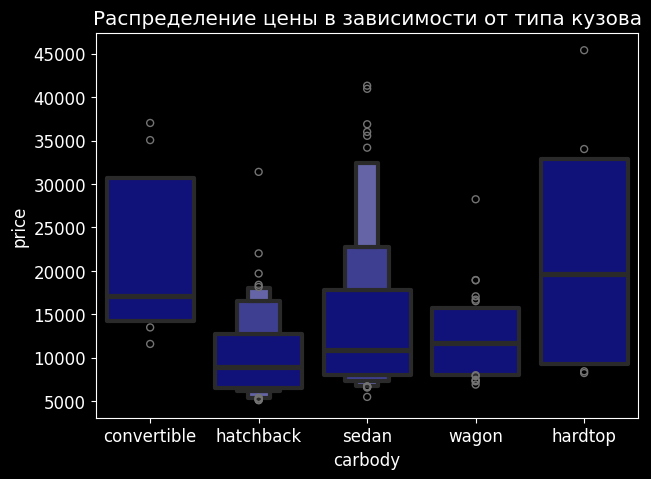

In [30]:
plt.title('Распределение цены в зависимости от типа кузова')
sns.boxenplot(x='carbody', y='price', data=df, **param_plt)
plt.show()

Мы видим сбалансированно невысокие цены на хэтчбеки и универсалы.\
Большой разброс цен на седаны.\
Высокие цены на кабриолеты (от 15000).\
И совершенно разные цены на хардтоп, так как это скорее модификация автомобиля, которая может относится\
к любой из категорий кузова.

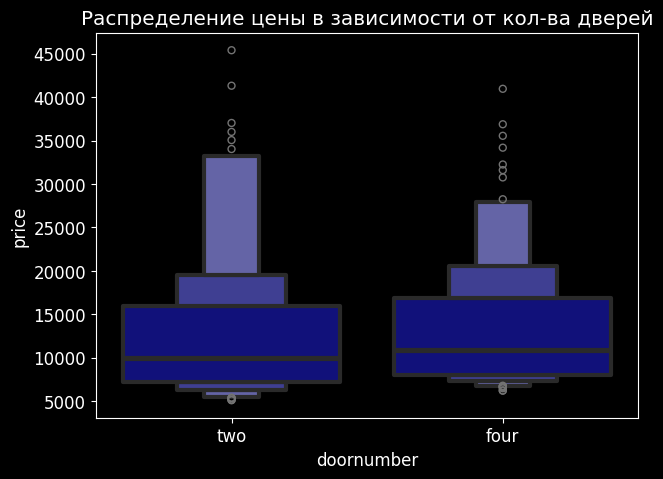

In [31]:
plt.title('Распределение цены в зависимости от кол-ва дверей')
sns.boxenplot(x='doornumber', y='price', data=df, **param_plt)
plt.show()

В данном датасете мы видим, что нет кол-во дверей не влияет на цену.\

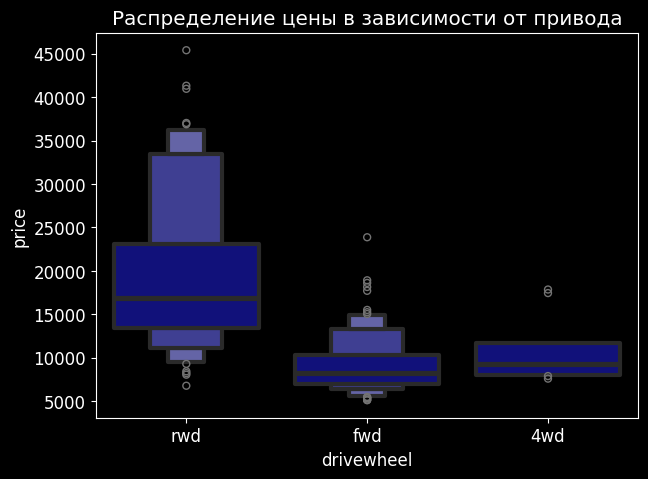

In [32]:
plt.title('Распределение цены в зависимости от привода')
sns.boxenplot(x='drivewheel', y='price', data=df, **param_plt)
plt.show()

Исправим ошибки в наименовании автомобилей и посмотрим их распределение.

На графике видно, что машин с передним приводом намного больше.\
Распределения по переднему и заднему приводу похожи.\
По полному приводу мало данных (это есть в графиках распределения).

In [33]:
df["carmark"] = (
    df.CarName.str.split()
    .str[0]
    .str.lower()
    .str.replace("vokswagen", "volkswagen")
    .replace("vw", "volkswagen")
    .replace("toyouta", "toyota")
    .replace("maxda", "mazda")
    .replace("porcshce", "porsche")
)

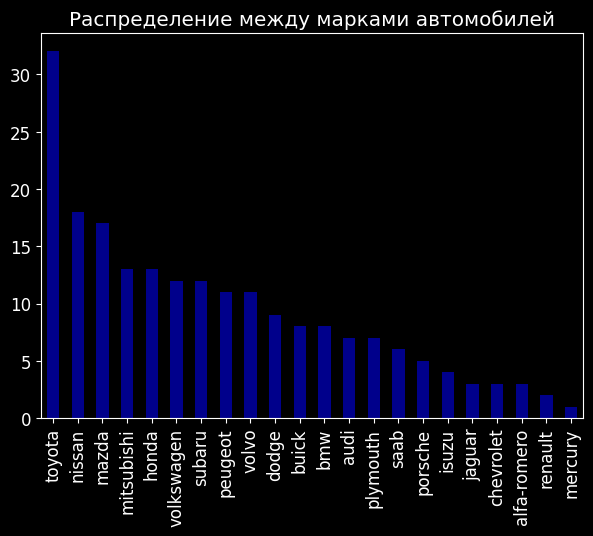

In [34]:
plt.title('Распределение между марками автомобилей')
df.carmark.value_counts().plot(kind='bar', **param_plt)
plt.show()

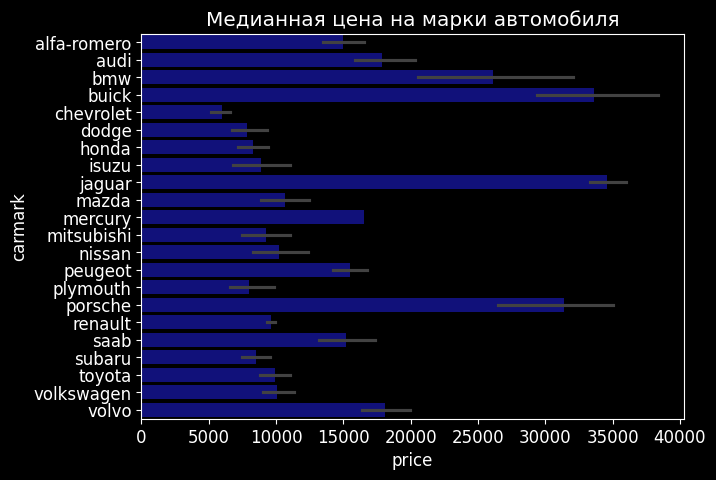

In [35]:
plt.title('Медианная цена на марки автомобиля')
sns.barplot(
    df.groupby(["carmark", "price"]).price.agg("median").to_frame(),
    y="carmark",
    x="price",
    **param_plt
)
plt.show()

На графике видно, что марки премиум-класса (бмв, порш, ягуар) стоят дороже.\
То есть данный признак имеет значение для ценообразования.

У столбцов compressionratio, fuelsystem и fueltype видно корреляцию равную 1.\
compressionratio мы смотрели выше, и это очевидно.\
Взглянем на fuelsystem.

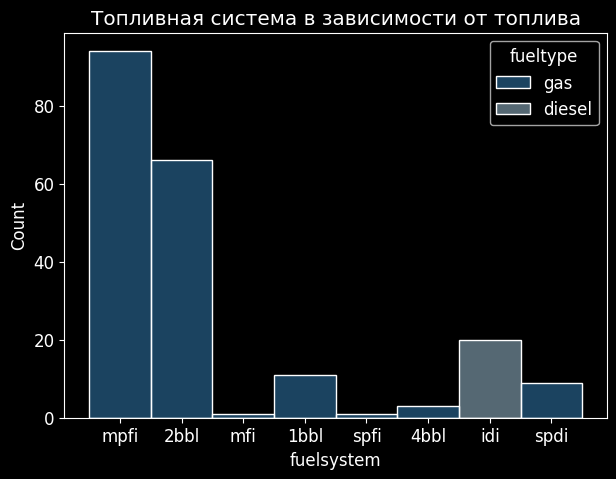

In [36]:
plt.title("Топливная система в зависимости от топлива")
sns.histplot(df, x=df.fuelsystem, hue=df.fueltype, palette="Blues_r")
plt.show()

Соответственно, мы можем оставить один из столбцов, тот у которого корреляция с целевым признаком выше.

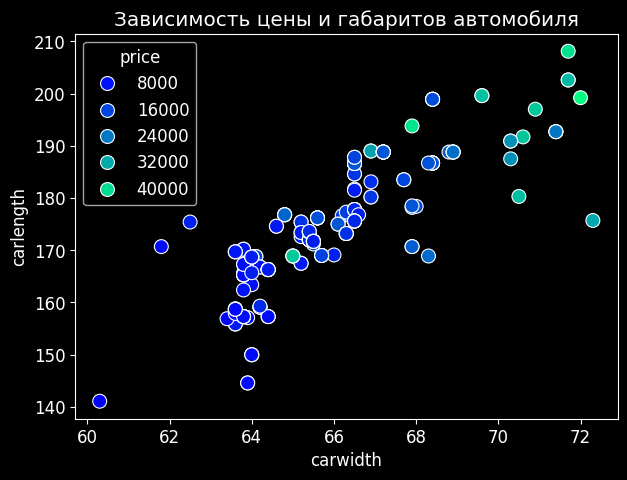

In [37]:
plt.title("Зависимость цены и габаритов автомобиля")
sns.scatterplot(x=df.carwidth, y=df.carlength, hue=df.price, palette="winter", s=100)
plt.show()

Мы видим, что зависимость цены от габаритов автомобиля практически линейная,\
габариты (длина и ширина) также зависимы.\
Можно ввести признак - площадь автомобиля.

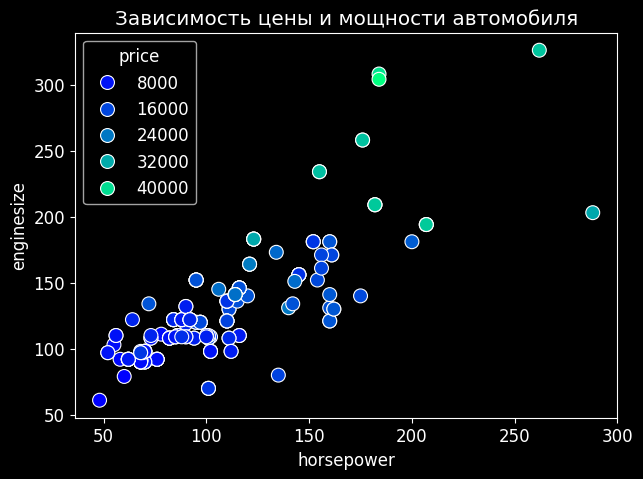

In [38]:
plt.title("Зависимость цены и мощности автомобиля")
sns.scatterplot(x=df.horsepower, y=df.enginesize, hue=df.price, palette="winter", s=100)
plt.show()

Мы видим, что зависимость цены от мощности автомобиля практически линейная,\
кол-во лошадей и объем двигателя также зависимы.

Посчитаем VIF (коэффициент инфляции дисперсии), он поможет выявить мультиколлинеарные признаки (в числовых).

In [39]:
corr_matrix = np.array(num_features.corr())
inv_corr_matrix = np.linalg.inv(corr_matrix)
mult_corr_feat = pd.DataFrame(
    np.diag(inv_corr_matrix), index=num_features.columns, columns=["VIF"]
).sort_values(by="VIF", ascending=False)
mult_corr_feat.style.background_gradient(cmap="Blues")

,VIF
citympg,27.824477
highwaympg,24.369050
curbweight,16.413566
carlength,9.423044
wheelbase,8.414016
horsepower,8.313121
enginesize,6.667017
carwidth,5.688037
carheight,2.292633
compressionratio,2.206752


Итого, такими признаками являются: citympg, highwaympg и curbweight.\
Снаряженная масса (curbweight) влияет на расход топлива и разгон автомобиля,\
масса напрямую зависит от размеров автомобиля.

*ВЫВОД:*
- Нужно проверить связь признака enginelocation с целевым и возможно исключить данный признак.
- Поверить корреляцию между объемом двигателя и кол-вом лс.
- Проверить корреляцию между пробегом по городу(citympg) и трассе(highwaympg).
- Есть столбцы cylindernumber и fuelsystem, где ряд значений занимает менее 1%. Возможно, есть смысл объединить их.
- Оставить один из столбцов в compressionratio, fuelsystem и fueltype из-за высокой корреляции.
- Столбцы doornumber, cylindernumber числовые.
- Столбец Symboling категориальный.
- Проверить признак doornumber на корреляцию с целевым.

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 4. Проверка гипотез.</div>

Н0: связи нет\
Н1: связь есть

Проверим связь между целевым признаком и признаками с корреляцией равной 1: compressionratio, fuelsystem и fueltype.

In [40]:
alpha = 0.05
for feat in ["fuelsystem", "fueltype"]:
    correlation, pvalue = stats.kendalltau(df.price, df[feat])
    print(f"Корреляция между price и {feat}: {correlation:.5f}, p: {pvalue:.15f},")

    print("отклоняем H0.") if pvalue < alpha else print("подтверждается H0.")

correlation, pvalue = stats.pearsonr(df.price, df.compressionratio)
print(
    f"Корреляция между price и compressionratio: {correlation:.5f}, p: {pvalue:.15f},"
)
print("отклоняем H0.") if pvalue < alpha else print("подтверждается H0.")

Корреляция между price и fuelsystem: 0.51013, p: 0.000000000000000,
отклоняем H0.
Корреляция между price и fueltype: -0.11442, p: 0.045950924364308,
отклоняем H0.
Корреляция между price и compressionratio: 0.06798, p: 0.332772361223805,
подтверждается H0.


Вывод: можно оставить 1 из 3 признаков: fuelsystem.

Проверим корреляцию между пробегом по городу(citympg) и трассе(highwaympg).

In [41]:
correlation, pvalue = stats.pearsonr(df.citympg, df.highwaympg)
print(f"Корреляция между citympg и highwaympg: {correlation:.5f}, p: {pvalue:.15f},")
print("отклоняем H0.") if pvalue < alpha else print("подтверждается H0.")

Корреляция между citympg и highwaympg: 0.97134, p: 0.000000000000000,
отклоняем H0.


Вывод: Корреляция очень высокая, можно сложить признаки и получить общий пробег автомобиля.

 Проверим связь признака enginelocation с целевым.

In [42]:
correlation, pvalue = stats.kendalltau(df.price, df.enginelocation)
print(f"Корреляция между price и enginelocation: {correlation:.5f}, p: {pvalue:.15f},")
print("отклоняем H0.") if pvalue < alpha else print("подтверждается H0.")

Корреляция между price и enginelocation: 0.15963, p: 0.005361642811118,
отклоняем H0.


Корреляция низкая, можно исключить данный признак.

In [43]:
correlation, pvalue = stats.pearsonr(df.horsepower, df.enginesize)
print(f"Корреляция между horsepower и enginesize: {correlation:.5f}, p: {pvalue:.15f},")
print("отклоняем H0.") if pvalue < alpha else print("подтверждается H0.")

Корреляция между horsepower и enginesize: 0.80977, p: 0.000000000000000,
отклоняем H0.


Проверим корреляцию кол-ва дверей и цены.

In [44]:
correlation, pvalue = stats.kendalltau(df.doornumber, df.price)
print(f"Корреляция между doornumber и price: {correlation:.5f}, p: {pvalue:.15f},")
print("отклоняем H0.") if pvalue < alpha else print("подтверждается H0.")

Корреляция между doornumber и price: -0.09697, p: 0.090736304606315,
подтверждается H0.


Да, связи нет. Можно удалить этот признак.

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> Вывод по разделу.</div>

<div class="alert alert-info">
<ul>
<li>Необходимо провести следующее преобразвание признаков:
<ul>
<li>Из столбца CarName выделить только марку автомобиля, а сам столбец удалить;
<li>Сложить пробег по городу(citympg) и трассе(highwaympg);
<li>Перевести столбец cylindernumber к числовому виду;
<li>Привести столбец Symboling к категориальному виду;
<li>Ввести признак площадь carwidth * carlength.
</ul>
<br>
<li>Кол-во признаков не должно приближаться к кол-ву строк поэтому:
<ul>
<li>Надо выделить главные признаки;
<li>Удалить признак enginelocation;
<li>Удалить признак doornumber;
<li>Удалить compressionratio и fueltype из-за высокой корреляции.
<ul>

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 5. Выбор задачи.</div>
Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

В данном датасете решается задача регресии - определение цены.

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 5. Выбор модели.</div>
Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

### 5.1. Разделение выборок.

In [45]:
X = df.drop(columns="price")
y = df.price

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=123, test_size=0.2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, random_state=123, test_size=0.2
)

### 5.2. Работа с признаками

Для удобства выведем корреляцию целевого признака с числовыми.

In [46]:
pd.DataFrame(df.corr(numeric_only=True)["price"]).style.background_gradient(
    cmap="Blues"
)

,price
symboling,-0.079978
wheelbase,0.577816
carlength,0.682920
carwidth,0.759325
carheight,0.119336
curbweight,0.835305
enginesize,0.874145
boreratio,0.553173
stroke,0.079443
compressionratio,0.067984


Немного преобразуем признаки при помощи энкодера и скалера.\
Также будем работать со столбцом carmark вместо CarName.

In [47]:
X_train_cor = X_train.copy()
X_train_cor = X_train_cor.drop("CarName", axis=1)

In [48]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "num_scaler",
            StandardScaler(),
            X_train_cor.select_dtypes(include="number").columns,
        ),
        (
            "encoder_cat",
            OneHotEncoder(drop="first", handle_unknown="ignore"),
            X_train_cor.select_dtypes(exclude="number").columns,
        ),
    ]
)

In [49]:
preprocessor.fit(X_train_cor)
X_train_cor = preprocessor.transform(X_train_cor)
cols = [x.split("__")[-1] for x in preprocessor.get_feature_names_out()]

5.2.1 Метод PLS - можем выделить числовые признаки.

In [50]:
pls = PLSRegression(n_components=10)
pls.fit(X_train_cor, y_train)

PLSRegression(n_components=10)

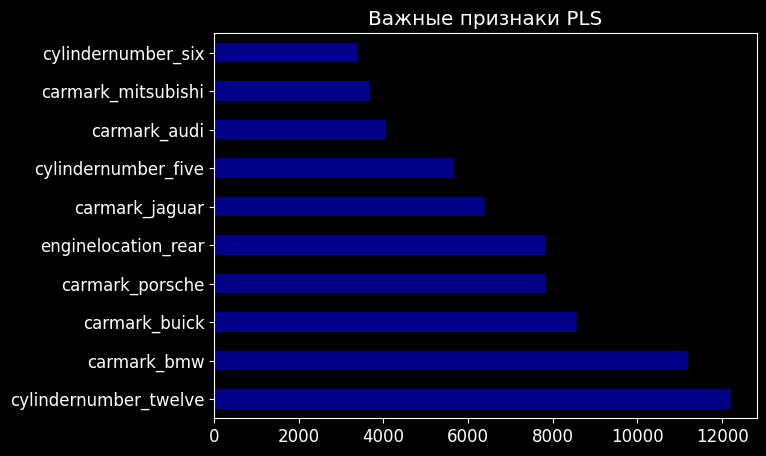

In [51]:
feature_importances = pd.Series(
    abs(pls.coef_[0]), cols
).sort_values(ascending=False)[:10]

plt.title("Важные признаки PLS")
feature_importances.plot(kind="barh", **param_plt)
plt.show()

PLS выделил признаки, которые связаны с кол-вом цилиндров и принадлежностью автомобиля\
к премиальному сегменту.\
Посмотрим другим методом.

5.2.1. Линейная регрессия.

In [52]:
lm = LinearRegression()
lm.fit(X_train_cor, y_train)
y_pred = lm.predict(X_train_cor)
r2_score(y_train, y_pred)

0.9735118894456655

In [53]:
X_val_cor = preprocessor.transform(X_val.drop("CarName", axis=1))
X_test_cor = preprocessor.transform(X_test.drop("CarName", axis=1))

/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [6, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [54]:
y_val_pred = lm.predict(X_val_cor)
r2_score(y_val, y_val_pred)

0.7816016934470071

Мы видим разницу в 0.2 между r2 на тренировочной и тестовой выборках.\
Посмотрим, какие признаки не важны с точки зрения линейной регрессии.


In [55]:
pd.DataFrame(abs(lm.coef_), index=cols, columns=["coef"]).sort_values(by="coef")[
    :10
].style.background_gradient(cmap="Blues_r")

,coef
citympg,9.257008
horsepower,13.935756
doornumber_two,115.578071
carmark_renault,242.982797
symboling,344.506123
boreratio,350.869187
enginetype_ohc,359.841880
carmark_nissan,365.056876
carmark_volvo,391.926229
carmark_peugeot,495.409579


In [56]:
rfecv = RFECV(estimator=lm, step=1, cv=5)
rfecv.fit(X_train_cor, y_train)
print(f"Оптимальное кол-во признаков: {rfecv.n_features_}")

Оптимальное кол-во признаков: 21


In [57]:
pd.DataFrame(rfecv.support_, index=cols, columns=["result"]).sort_values(
    by="result", ascending=False
)[:21]

,result
cylindernumber_six,True
carbody_hatchback,True
enginelocation_rear,True
enginetype_ohcf,True
enginetype_rotor,True
cylindernumber_five,True
cylindernumber_four,True
cylindernumber_three,True
cylindernumber_twelve,True
cylindernumber_two,True


Выделенные признаки похожи на признаки из PLS. К ним добавляется снаряженная масса и типы двигателя.

In [58]:
del X_train['carmark']
del X_test['carmark']
del X_val['carmark']

Попробуем выявить лучшую модель на основании:
- всех признаков
- признаков, выделенных в процессе EDA.

Создадим классы для трансформации признаков.

In [59]:
class CustomColTransformer(TransformerMixin, BaseEstimator, OneToOneFeatureMixin):
    """Class features transformer"""

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X) -> pd.DataFrame:
        X["carmark"] = self.transform_carname(X)
        X.carmark = (
            X.carmark.str.replace("vokswagen", "volkswagen")
            .str.replace("vw", "volkswagen")
            .replace("toyouta", "toyota")
            .replace("maxda", "mazda")
            .replace("porcshce", "porsche")
        )
        X["mpg"] = self.create_col_mpg(X)
        X['perimeter'] = self.create_col_perimeter(X)
        return X

    def transform_carname(self, X):
        return X["CarName"].str.split().str[0].str.lower()

    def create_col_mpg(self, X):
        return X.citympg + X.highwaympg
    
    def create_col_perimeter(self, X):
        return X.carlength + X.carwidth

In [60]:
class ColumntoNumTransformer(TransformerMixin, BaseEstimator, OneToOneFeatureMixin):
    """Class features transformer columns from categorical to number"""

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X) -> pd.DataFrame:
        # X["doornumber"] = self.transform_doornumber(X)
        X["cylindernumber"] = self.transform_cylindernumber(X)
        return X

    # def transform_doornumber(self, X):
    #     doornumber_map = {"two": 2, "four": 4}
    #     return df["doornumber"].map(doornumber_map)

    def transform_cylindernumber(self, X):
        cylindernumber_map = {
            "two": 2,
            "four": 4,
            "six": 6,
            "five": 5,
            "three": 3,
            "twelve": 12,
            "eight": 8,
        }
        return df["cylindernumber"].map(cylindernumber_map)

In [61]:
class ColumntoCatTransformer(TransformerMixin, BaseEstimator, OneToOneFeatureMixin):
    """Class features transformer columns from number to categorical"""

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X) -> pd.DataFrame:
        X["symboling"] = self.transform_symboling(X)
        return X

    def transform_symboling(self, X):
        return X.symboling.astype("category")

In [62]:
class ColumnsDropper(TransformerMixin, BaseEstimator, OneToOneFeatureMixin):
    """Class for drop features"""

    def fit(self, X, y=None):
        self.n_features_in_ = X.shape[1]
        return self

    def transform(self, X) -> pd.DataFrame:
        X.drop(
            columns=[
                "citympg",
                "highwaympg",
                "CarName",
                "compressionratio",
                "fueltype",
                "enginelocation",
                "doornumber",
                "carlength",
                "carwidth",
            ],
            axis=1,
            inplace=True,
        )

        return X

In [63]:
# пайплайн по работе с признаками
transform_feat = Pipeline(
    [
        ("col2num", ColumntoNumTransformer()),
        ("col2cat", ColumntoCatTransformer()),
        ("transform", CustomColTransformer()),
        ("dropper", ColumnsDropper()),
    ]
)

In [64]:
# определим признаки для пайплайна с генерацией фичей
num_features = [
    "symboling",
    "wheelbase",
    "perimeter",
    "carheight",
    "curbweight",
    "enginesize",
    "boreratio",
    "stroke",
    "horsepower",
    "peakrpm",
    "mpg",
    "cylindernumber",
]
cat_features = [
    "aspiration",
    "carbody",
    "drivewheel",
    "enginetype",
    "fuelsystem",
    "carmark",
]

In [65]:
# пайплайн с генерацией новых фичей
pipe_gen = Pipeline(
    [
        (
            "transform_feat",
            transform_feat,
        ),
        (
            "preproccesing",
            ColumnTransformer(
                transformers=[
                    ("num_scaler", StandardScaler(), num_features),
                    (
                        "encoder_cat",
                        OneHotEncoder(drop="first", handle_unknown="ignore"),
                        cat_features,
                    ),
                ]
            ),
        ),
        (
            "clf",
            None,
        ),
    ]
)

In [66]:
# пайплайн для моделей без работы над признаками
pipe = Pipeline(
    [
        (
            "preproccesing",
            ColumnTransformer(
                transformers=[
                    (
                        "num_scaler",
                        StandardScaler(),
                        X_train.select_dtypes(include="number").columns,
                    ),
                    (
                        "encoder_cat",
                        OneHotEncoder(drop="first", handle_unknown="ignore"),
                        X_train.select_dtypes(exclude="number").columns,
                    ),
                ]
            ),
        ),
        (
            "clf",
            None,
        ),
    ]
)

### 5.3. Обучение моделей

In [67]:
# зададим параметры
scoring = "neg_mean_absolute_error"
estimators = (10, 161, 50)
learning_rate = [0.01, 0.05, 0.1]
max_depth = range(2, 23, 5)
min_samples_split = range(2, 9, 2)
min_samples_leaf = range(1, 6, 2)
cv = 5

In [68]:
models = [
    {
        "clf": (DecisionTreeRegressor(random_state=123),),
        "clf__max_depth": max_depth,
        "clf__min_samples_leaf": min_samples_leaf,
        "clf__min_samples_split": min_samples_split,
    },
    {
        "clf": (RandomForestRegressor(random_state=123),),
        "clf__max_depth": max_depth,
        "clf__min_samples_leaf": min_samples_leaf,
        "clf__min_samples_split": min_samples_split,
        "clf__n_estimators": estimators,
    },
    {
        "clf": (XGBRegressor(random_state=123),),
        "clf__max_depth": max_depth,
        "clf__learning_rate": learning_rate,
        "clf__n_estimators": estimators,
        "clf__ eval_set": [(X_train, y_train), (X_val, y_val)],
    },
]
params = [{**model} for model in models]

5.3.1. без feature engineering

In [69]:
grid_search = GridSearchCV(pipe, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1)

In [70]:
warnings.filterwarnings("ignore")
grid_search.fit(X_train, y_train)

/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 9] during transform. These u

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preproccesing',
                                        ColumnTransformer(transformers=[('num_scaler',
                                                                         StandardScaler(),
                                                                         Index(['symboling', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg'],
      dtype='object')),
                                                                        ('encoder_cat',
                                                                         OneHotEncoder(d...
198    18420.000
192    13845.000
99      8949.000
121     6692.000
43      6785.000
173     8948.000
120     6229.000
146     7463.000
77      6189.000
55     10945.000
90      7099.000
75     16503.000
125    22018.000
157     7198.000
79      7689.000
135    15510.000
170    11199.000
Name: price, dtype: float64)],
                          'clf__learning_rate': [0.01, 0.05, 0.1],
                          'clf__max_depth': range(2, 23, 5),
                          'clf__n_estimators': (10, 161, 50)}],
             scoring='neg_mean_absolute_error')

In [71]:
grid_search.best_estimator_[1]

RandomForestRegressor(max_depth=7, min_samples_split=8, n_estimators=50,
                      random_state=123)

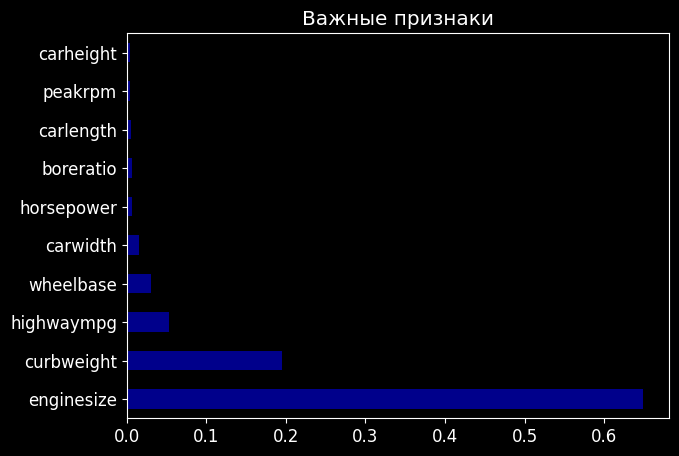

In [72]:
# Выбор важных признаков
feature_importances = pd.Series(
    grid_search.best_estimator_[1].feature_importances_,
    index=[
        x.split("__")[-1]
        for x in grid_search.best_estimator_[0].get_feature_names_out()
    ],
).sort_values(ascending=False)[:10]
plt.title("Важные признаки")
feature_importances.plot(kind="barh", **param_plt)
plt.show()

In [73]:
y_pred_val = grid_search.predict(X_val)
mean_absolute_error(y_val, y_pred_val)

1654.7721464437595

5.3.2. с feature engineering

In [74]:
grid_search_fe = GridSearchCV(
    pipe_gen, param_grid=params, cv=cv, scoring=scoring, n_jobs=-1
)

In [75]:
grid_search_fe.fit(X_train, y_train)

/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/olgatorres/PycharmProjects/ArchitectorAI/venv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transform_feat',
                                        Pipeline(steps=[('col2num',
                                                         ColumntoNumTransformer()),
                                                        ('col2cat',
                                                         ColumntoCatTransformer()),
                                                        ('transform',
                                                         CustomColTransformer()),
                                                        ('dropper',
                                                         ColumnsDropper())])),
                                       ('preproccesing',
                                        ColumnTransformer(transformers=[('num_scaler',
                                                                         StandardScaler(),
                                                                         ['symboling',
                                                                          'wheelbase',
                                                                          'perimeter',
                                                                          'carheight',...
198    18420.000
192    13845.000
99      8949.000
121     6692.000
43      6785.000
173     8948.000
120     6229.000
146     7463.000
77      6189.000
55     10945.000
90      7099.000
75     16503.000
125    22018.000
157     7198.000
79      7689.000
135    15510.000
170    11199.000
Name: price, dtype: float64)],
                          'clf__learning_rate': [0.01, 0.05, 0.1],
                          'clf__max_depth': range(2, 23, 5),
                          'clf__n_estimators': (10, 161, 50)}],
             scoring='neg_mean_absolute_error')

In [76]:
grid_search_fe.best_estimator_[2]

RandomForestRegressor(max_depth=7, min_samples_split=4, n_estimators=50,
                      random_state=123)

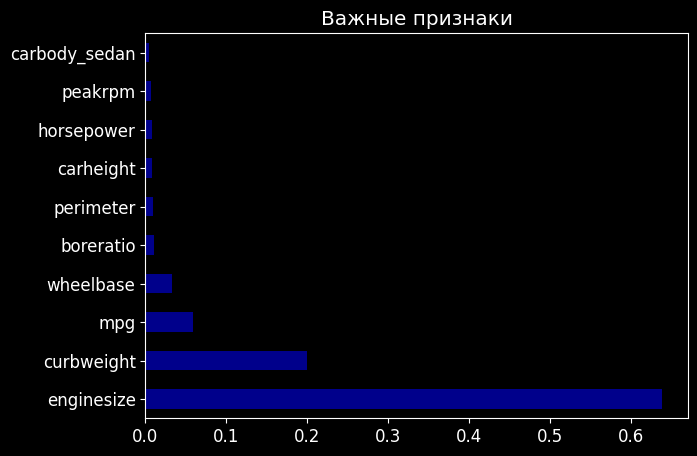

In [77]:
# Выбор важных признаков
feature_importances = pd.Series(
    grid_search_fe.best_estimator_[2].feature_importances_,
    index=[
        x.split("__")[-1]
        for x in grid_search_fe.best_estimator_[1].get_feature_names_out()
    ],
).sort_values(ascending=False)[:10]
plt.title("Важные признаки")
feature_importances.plot(kind="barh", **param_plt)
plt.show()

In [78]:
y_pred_val = grid_search_fe.predict(X_val)
mean_absolute_error(y_val, y_pred_val)

1417.643150280005

Попробуем простую полносвязную нейронную сеть.

In [79]:
y_train, y_val = y_train.to_numpy(), y_val.to_numpy()

In [80]:
scaler = StandardScaler()
X_train_cor = scaler.fit_transform(X_train_cor)
X_val_cor = scaler.transform(X_val_cor)
X_test_cor = scaler.transform(X_test_cor)

In [81]:
def create_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_dim=X_train_cor.shape[1]))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  )
    
    return model

In [82]:
model = create_model()
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

history = model.fit(
    X_train_cor,
    y_train,
    validation_data=(X_val_cor, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping],
)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 13382.5713 - val_loss: 12966.9297
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15272.6963 - val_loss: 12965.0469
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14234.8457 - val_loss: 12962.1836
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13831.4453 - val_loss: 12957.5732
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15829.5664 - val_loss: 12950.4424
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13687.4238 - val_loss: 12939.4404
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13112.1855 - val_loss: 12923.4863
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14108.8691 - val_loss: 12900.7041
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14138.9014 - val_loss: 12869.4150
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14319.0674 - val_loss: 12826.6016
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14349.879

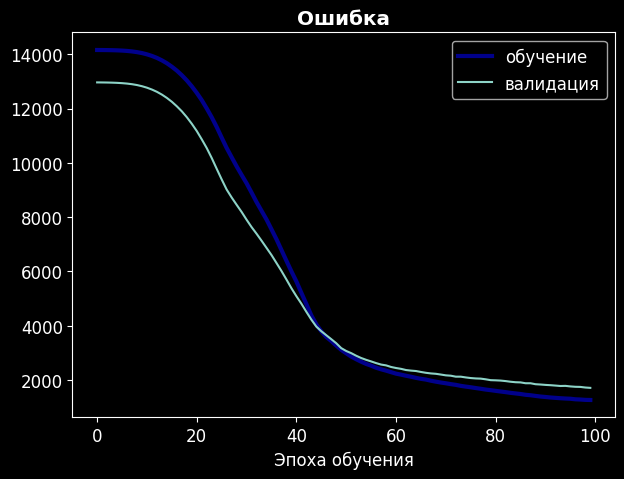

In [83]:
plt.title("Ошибка", fontweight="bold")
plt.plot(history.history['loss'], label="обучение", **param_plt)
plt.plot(history.history['val_loss'], label="валидация")
plt.xlabel("Эпоха обучения")
plt.legend()
plt.show()

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> 6. Прогноз.</div>
Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)\
Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

Для оценки предсказания цены лучше подходит метрика mean absolute error, так как она покажет отклонение\
в абсолютном выражении и будет понятна заказчику.

In [84]:
y_pred_test = grid_search.predict(X_test)
mean_absolute_error(y_test, y_pred_test)

1198.4569973800708

In [85]:
y_pred_test = grid_search_fe.predict(X_test)
mean_absolute_error(y_test, y_pred_test)

1158.468751359428

In [86]:
y_pred = model.predict(X_test_cor)
mean_absolute_error(y_test, y_pred)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


1653.0232350419208

## <div style="border: 1px solid purple; padding: 10px; color: SteelBlue"> Вывод по разделу.</div>
Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

Посчитаем случайное значение метрики:

In [87]:
mean_absolute_error(y_test, [y_test.mean()] * len(y_test))

4040.3164782867343

<div class="alert alert-info">
Для решения данной задачи необходимо использовать машинное обучение.

Лучшая метрика 1158 RandomForest против 4040 случайного выбора.\
Надо отметить, что работа над признаками не сильно изменила результат (на 40 единиц).